<button data-commandLinker-command="progressivis:cleanup_and_run" data-commandlinker-args='{"index": 1}' href="#">Run ProgressiVis</button>

In [1]:
from ipyprogressivis.widgets import get_header, Constructor
from ipyprogressivis.widgets.chaining.utils import create_root
from ipyprogressivis.widgets.chaining.custom import *
import panel as pn 
header = get_header()
display(header.talker)
display(header.backup)
pn.extension('ace', 'jsoneditor', 'ipywidgets')
_ = header.constructor
with header.modules_out:
    display(header.board)
with header.widgets_out:
    display(header.manager)
header.talker.labcommand("notebook:hide-cell-code")
%reload_ext ipyprogressivis.magics
create_root(header.backup)

In [3]:
# progressivis-snippets
import numpy as np
@register_function
@np.vectorize
def rain_level(val: float) -> str:
    if np.isnan(val) or val < 0.07:
        return "No"
    if val < 0.19:
        return "Light"
    return "Rain"

## root

In [2]:
# do not run this cell
display(header.constructor)
header.constructor.start_scheduler()
header.talker.labcommand('notebook:hide-cell-code')

Constructor(children=(IntProgress(value=0, description='Starting ProgressiVis ...', max=2, style=ProgressStyle…

Starting scheduler
# Scheduler added module(s): ['sink_1', 'variable_1']


## Weather

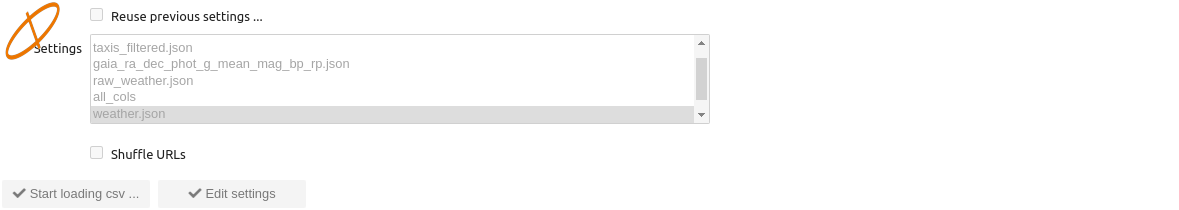

In [4]:
Constructor.widget('Weather', 0)

## Taxis

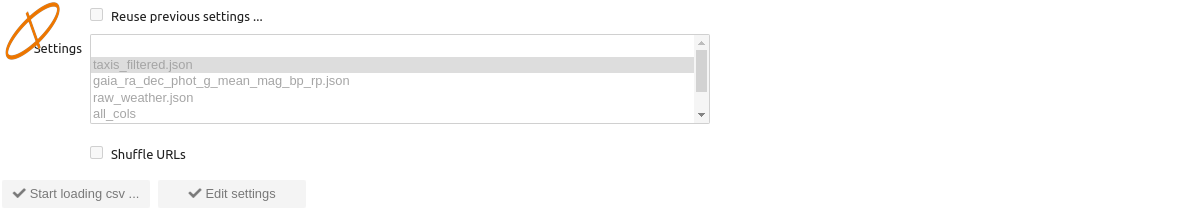

In [5]:
Constructor.widget('Taxis', 0)

## Join

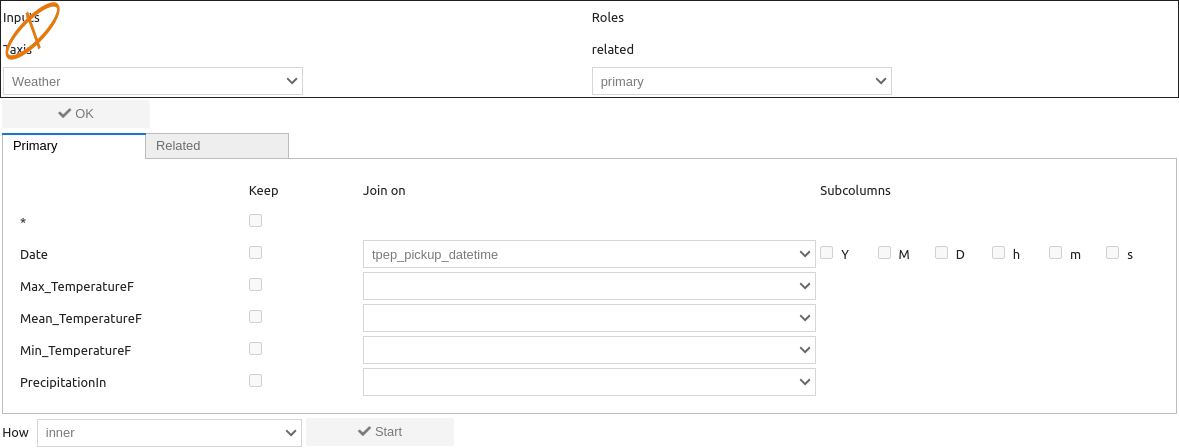

In [6]:
Constructor.widget('Join', 0)

## View

# Scheduler added module(s): ['data_shape_1', 'sink_3']


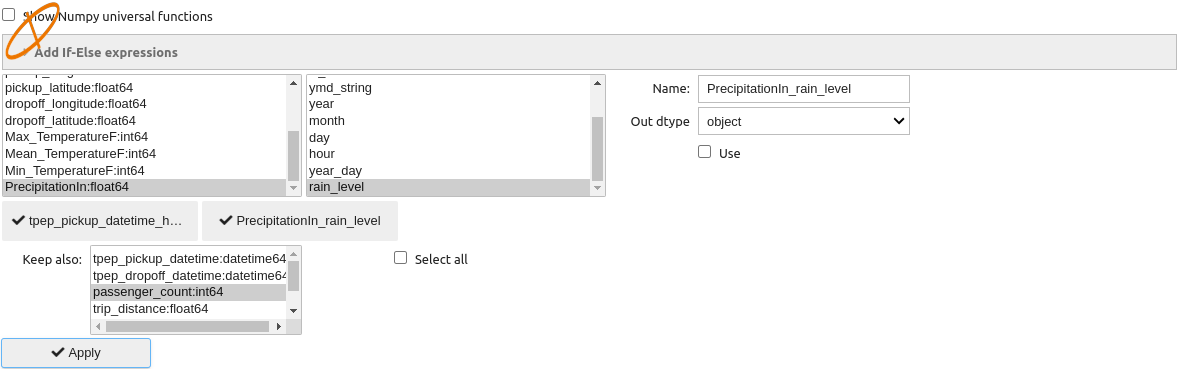

# Scheduler deleted module(s): {'data_shape_1', 'sink_3'}


In [7]:
Constructor.widget('View', 0)

## Group by

# Scheduler added module(s): ['data_shape_1', 'sink_4']


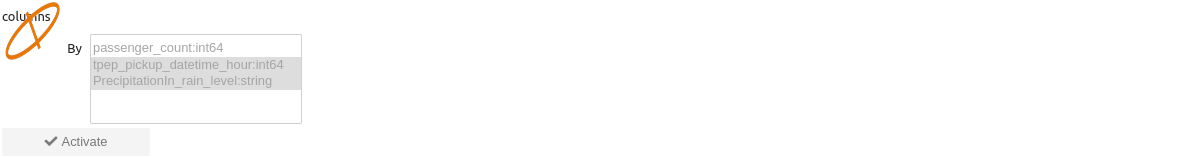

# Scheduler deleted module(s): {'data_shape_1', 'sink_4'}


In [8]:
Constructor.widget('Group by', 0)

## Aggregate

# Scheduler added module(s): ['data_shape_1', 'sink_5']


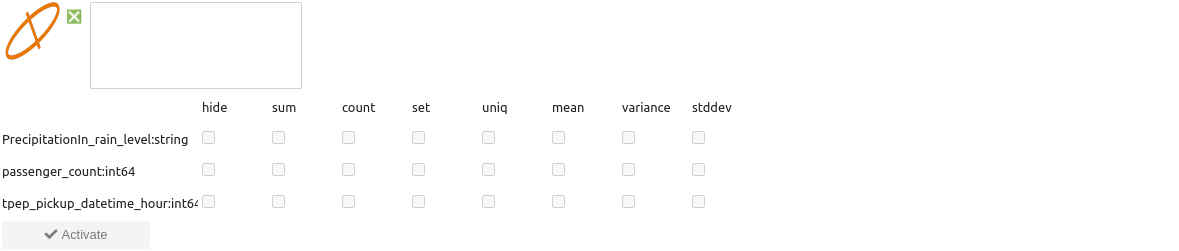

# Scheduler deleted module(s): {'sink_5', 'data_shape_1'}


In [9]:
Constructor.widget('Aggregate', 0)

## Any Vega

# Scheduler added module(s): ['data_shape_1', 'sink_6']


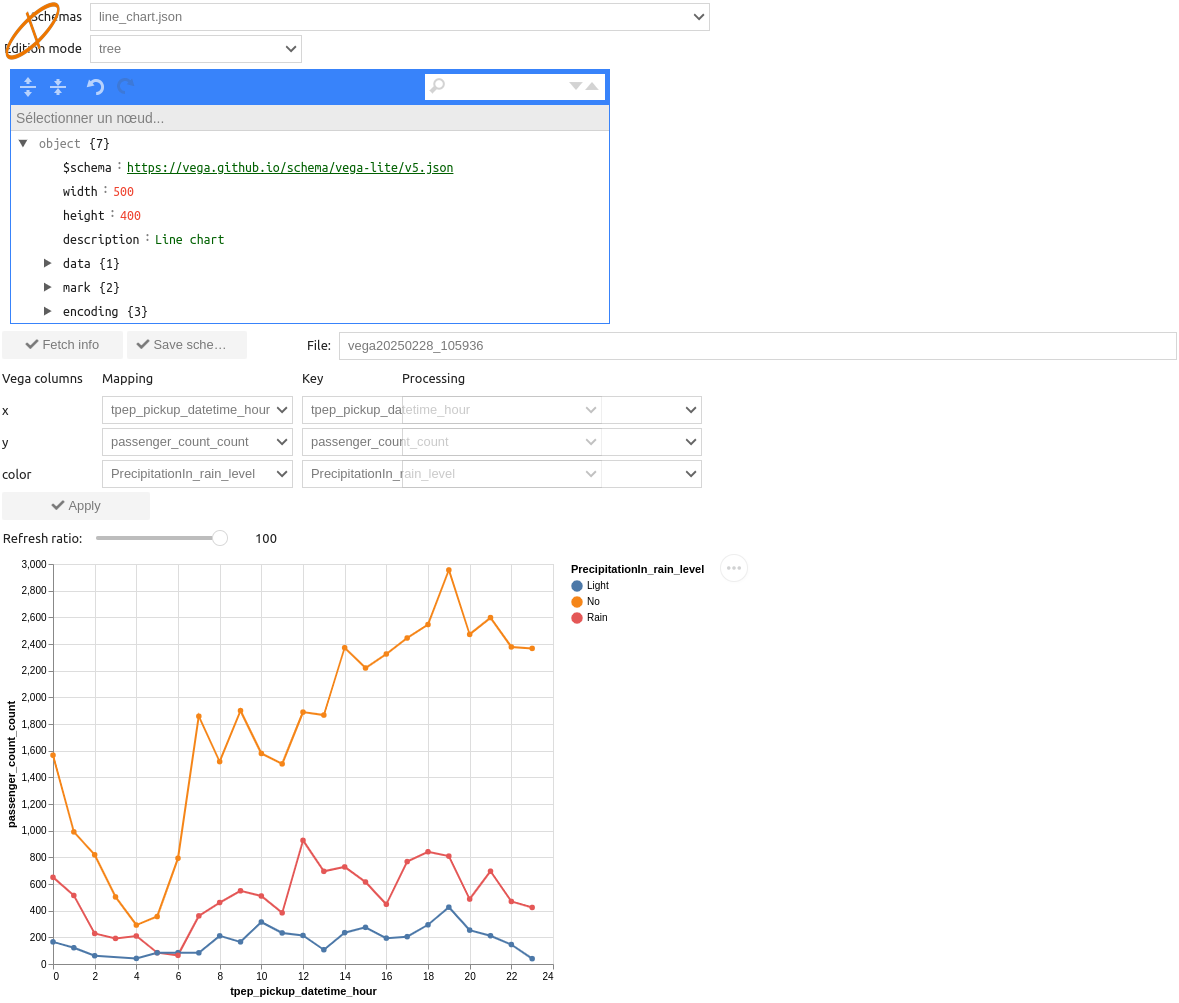

In [10]:
Constructor.widget('Any Vega', 0)